In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
df = pd.read_csv('preprocessed_data.csv')

In [ ]:
df_train=df[(df.DATE>=19570131)&(df.DATE<19741231)]
df_validation=df[(df.DATE>=19750131)&(df.DATE<19861231)]
df_test=df[(df.DATE>=19870131)&(df.DATE<20161230)]
df_train.shape,df_validation.shape,df_test.shape

In [4]:
X_train=df_train.drop(["DATE","permno","RET"],axis=1).values
X_validation=df_validation.drop(["DATE","permno","RET"],axis=1).values
X_test=df_test.drop(["DATE","permno","RET"],axis=1).values
y_train=df_train[["RET"]].values
y_validation=df_validation[["RET"]].values
y_test=df_test[["RET"]].values

In [5]:
def rsquare_oos(ytrue,ypred):
    dif2=np.sum(np.power(ytrue-ypred,2))
    return 1-dif2/np.sum(np.power(ytrue,2))

In [6]:
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

In [ ]:
lr=LinearRegression()
lr.fit(X_train,y_train)
y_test_pred = lr.predict(X_test)
score_train1 = rsquare_oos(y_test, y_test_pred)

pcr = make_pipeline(PCA(n_components=3), LinearRegression())
pcr.fit(X_train,y_train)
y_test_pred = pcr.predict(X_test)
score_train2 = rsquare_oos(y_test, y_test_pred)

pls=PLSRegression(n_components=3)
pls.fit(X_train,y_train)
y_test_pred = pls.predict(X_test)
score_train3 = rsquare_oos(y_test, y_test_pred)

X_train=df_train[['mom12m','bm','mvel1']].values
X_test=df_test[['mom12m','bm','mvel1']].values
y_train=df_train[["RET"]].values
y_test=df_test[["RET"]].values
lr=LinearRegression()
lr.fit(X_train,y_train)
y_test_pred = lr.predict(X_test)
score_train4 = rsquare_oos(y_test, y_test_pred)

print('OLS R2 (bottom):', score_train1)
print('OLS-3 R2 (bottom):', score_train4)
print('PCR R2 (bottom):', score_train2)
print('PLS R2 (bottom):', score_train3)



In [ ]:
#The recursive performance evaluation scheme for OLS
train_score=[0]*12
validation_score=[0]*12
test_score=[0]*12
for i in tqdm(range(0,12)):
    #print('Evaluation Window {}:\nTrain df:1960-{}\nValuation df:{}-{}\nTest df:{}-{}'.format(i,1978+i,1978+i,1990+i,1990+i,1991+i))
    df_train=df[(df.DATE>=19570131)&(df.DATE<19741231+i*10000)]
    df_validation=df[(df.DATE>=19750131+i*10000)&(df.DATE<19861231+i*10000)]
    df_test=df[(df.DATE>=19750131+i*10000)&(df.DATE<20041230+i*10000)]
    
    X_train=df_train.drop(["DATE","permno","RET"],axis=1).values
    X_validation=df_validation.drop(["DATE","permno","RET"],axis=1).values
    X_test=df_test.drop(["DATE","permno","RET"],axis=1).values
    y_train=df_train[["RET"]].values
    y_validation=df_validation[["RET"]].values
    y_test=df_test[["RET"]].values
    
    lr=LinearRegression()
    lr.fit(X_train,y_train)
    y_train_pred=lr.predict(X_train)
    train_score[i]=rsquare_oos(y_train,y_train_pred)
    y_validation_pred=lr.predict(X_validation)
    validation_score[i]=rsquare_oos(y_validation,y_validation_pred)
    y_test_pred=lr.predict(X_test)
    test_score[i]=rsquare_oos(y_test,y_test_pred)
    
    #del df_train,df_validation,df_test,X_train,y_train,X_test,y_test,X_validation,y_validation
    
validation_score = np.array(validation_score)
test_score = np.array(test_score)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("Simple Linear Regression OLS")
year=np.arange(1975,1987)
plt.plot(year, validation_score)
plt.xlabel("The year for test")
plt.ylabel("Validation score--R-square")
plt.subplot(1,2,2)
year=np.arange(1976,1988)
plt.plot(year,test_score)
plt.xlabel("The year for test")
plt.ylabel("Test score--R-square")
plt.show()

{'Coefficients': {'ep_macro': 0.13378407923421476,
  'tbl': 0.10122419978458569,
  'svar': 0.09547128684149106,
  'dfy': 0.08903778275070054,
  'dp': 0.08520356276377948,
  'bm_macro': 0.05439586463161295,
  'tms': 0.03200923304824355,
  'ntis': 0.03200413154868977,
  'idiovol': 0.030321063340030756,
  'dolvol': 0.026094286825668996,
  'mom1m': 0.02077180052583743,
  'zerotrade': 0.020639269063457637,
  'retvol': 0.02028742922585193,
  'std_turn': 0.019800918744417938,
  'baspread': 0.01909192798136667,
  'chmom': 0.013731487790087938,
  'mvel1': 0.013591491124743008,
  'indmom': 0.009326953279629797,
  'mom6m': 0.009099353065859758,
  'maxret': 0.008558451602017413}}

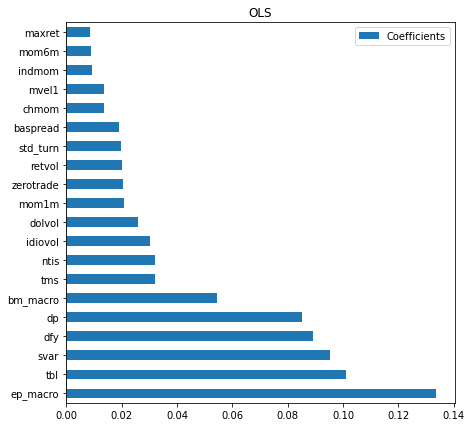

In [26]:
X_train=df_train.drop(["DATE","permno","RET"],axis=1)
coefs = pd.DataFrame(
   abs(lr.coef_.T),
   columns=['Coefficients'], index=X_train.columns
)
coefs = coefs/np.sum(coefs)
coefs = coefs.sort_values(by = 'Coefficients', ascending=False)[:20]
coefs.plot(kind='barh', figsize=(9, 7))
plt.title('OLS')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)
dic = coefs.to_dict()
dic
#np.save('OLS_dict.npy', dic) 

In [ ]:
#The recursive performance evaluation scheme for OLS-3
train_score=[0]*29
validation_score=[0]*29
test_score=[0]*29
for i in tqdm(range(0,29)):
    #print('Evaluation Window {}:\nTrain df:1960-{}\nValuation df:{}-{}\nTest df:{}-{}'.format(i,1978+i,1978+i,1990+i,1990+i,1991+i))
    df_train=df[(df.DATE>=19570131)&(df.DATE<19741231+i*10000)]
    df_validation=df[(df.DATE>=19750131+i*10000)&(df.DATE<19861231+i*10000)]
    df_test=df[(df.DATE>=19750131+i*10000)&(df.DATE<20041230+i*10000)]
    
    X_train=df_train[['mom12m','bm','mvel1']].values
    X_validation=df_validation[['mom12m','bm','mvel1']].values
    X_test=df_test[['mom12m','bm','mvel1']].values
    y_train=df_train[["RET"]].values
    y_validation=df_validation[["RET"]].values
    y_test=df_test[["RET"]].values
    
    lr=LinearRegression()
    lr.fit(X_train,y_train)
    y_train_pred=lr.predict(X_train)
    train_score[i]=rsquare_oos(y_train,y_train_pred)
    y_validation_pred=lr.predict(X_validation)
    validation_score[i]=rsquare_oos(y_validation,y_validation_pred)
    y_test_pred=lr.predict(X_test)
    test_score[i]=rsquare_oos(y_test,y_test_pred)
    
    del df_train,df_validation,df_test,X_train,y_train,X_test,y_test,X_validation,y_validation
    
validation_score = np.array(validation_score)
test_score = np.array(test_score)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("OLS")
year=np.arange(1975,2004)
plt.plot(year, validation_score)
plt.xlabel("The year for test")
plt.ylabel("Validation score--R-square")
plt.subplot(1,2,2)
year=np.arange(1976,2005)
plt.plot(year,test_score)
plt.xlabel("The year for test")
plt.ylabel("Test score--R-square")
plt.show()

In [ ]:
#The recursive performance evaluation scheme for PCR
train_score=[0]*29
validation_score=[0]*29
test_score=[0]*29
pcr_n = [0]*29
for i in tqdm(range(0,29)):
    #print('Evaluation Window {}:\nTrain df:1960-{}\nValuation df:{}-{}\nTest df:{}-{}'.format(i,1978+i,1978+i,1990+i,1990+i,1991+i))
    df_train=df[(df.DATE>=19570131)&(df.DATE<19741231+i*10000)]
    df_validation=df[(df.DATE>=19750131+i*10000)&(df.DATE<19861231+i*10000)]
    df_test=df[(df.DATE>=19750131+i*10000)&(df.DATE<20041230+i*10000)]
    
    X_train=df_train.drop(["DATE","permno","RET"],axis=1).values
    X_validation=df_validation.drop(["DATE","permno","RET"],axis=1).values
    X_test=df_test.drop(["DATE","permno","RET"],axis=1).values
    y_train=df_train[["RET"]].values
    y_validation=df_validation[["RET"]].values
    y_test=df_test[["RET"]].values
    
    best_pcr = None
    best_score = 0
    for n in range(1, 21):
        pcr = make_pipeline(PCA(n_components=n), LinearRegression())
        pcr.fit(X_train,y_train)
        y_train_pred=pcr.predict(X_train)
        train_score[i]=rsquare_oos(y_train,y_train_pred)
        y_validation_pred=pcr.predict(X_validation)
        validation_score[i]=rsquare_oos(y_validation,y_validation_pred)
        if validation_score[i] > best_score:
            best_score = validation_score[i]
            best_pcr = pcr
            pcr_n[i] = n
            
    y_test_pred = best_pcr.predict(X_test)
    test_score[i]=rsquare_oos(y_test,y_test_pred)
    
    del df_train,df_validation,df_test,X_train,y_train,X_test,y_test,X_validation,y_validation
    
validation_score = np.array(validation_score)
test_score = np.array(test_score)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("PCR")
year=np.arange(1975,2004)
plt.plot(year, validation_score)
plt.xlabel("The year for test")
plt.ylabel("Validation score--R-square")
plt.subplot(1,2,2)
year=np.arange(1976,2005)
plt.plot(year,test_score)
plt.xlabel("The year for test")
plt.ylabel("Test score--R-square")
plt.show()

In [ ]:
#The recursive performance evaluation scheme for PLS
train_score=[0]*29
validation_score=[0]*29
test_score=[0]*29
pcr_n = [0]*29
for i in tqdm(range(0,29)):
    #print('Evaluation Window {}:\nTrain df:1960-{}\nValuation df:{}-{}\nTest df:{}-{}'.format(i,1978+i,1978+i,1990+i,1990+i,1991+i))
    df_train=df[(df.DATE>=19570131)&(df.DATE<19741231+i*10000)]
    df_validation=df[(df.DATE>=19750131+i*10000)&(df.DATE<19861231+i*10000)]
    df_test=df[(df.DATE>=19750131+i*10000)&(df.DATE<20041230+i*10000)]
    
    X_train=df_train[['mom12m','bm','mvel1']].values
    X_validation=df_validation[['mom12m','bm','mvel1']].values
    X_test=df_test[['mom12m','bm','mvel1']].values
    y_train=df_train[["RET"]].values
    y_validation=df_validation[["RET"]].values
    y_test=df_test[["RET"]].values
    
    best_pls = None
    best_score = 0
    for n in range(1, 21): 
        pls=PLSRegression(n_components=3)
        pls.fit(X_train,y_train)
        y_train_pred=pls.predict(X_train)
        train_score[i]=rsquare_oos(y_train,y_train_pred)
        y_validation_pred=pls.predict(X_validation)
        validation_score[i]=rsquare_oos(y_validation,y_validation_pred)
        pls_n[i] = n
        
    y_test_pred=pls.predict(X_test)
    test_score[i]=rsquare_oos(y_test,y_test_pred)
    
    del df_train,df_validation,df_test,X_train,y_train,X_test,y_test,X_validation,y_validation
    
validation_score = np.array(validation_score)
test_score = np.array(test_score)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("PLS")
year=np.arange(1975,2004)
plt.plot(year, validation_score)
plt.xlabel("The year for test")
plt.ylabel("Validation score--R-square")
plt.subplot(1,2,2)
year=np.arange(1976,2005)
plt.plot(year,test_score)
plt.xlabel("The year for test")
plt.ylabel("Test score--R-square")
plt.show()

In [ ]:
# select important features
X_train=df_train.drop(["DATE","permno","RET"],axis=1).values
X_validation=df_validation.drop(["DATE","permno","RET"],axis=1).values
X_test=df_test.drop(["DATE","permno","RET"],axis=1).values
y_train=df_train[["RET"]].values
y_validation=df_validation[["RET"]].values
y_test=df_test[["RET"]].values

pcr = make_pipeline(PCA(n_components=3), LinearRegression())
pcr.fit(X_train,y_train)
y_test_pred = pcr.predict(X_test)
score_pcr = rsquare_oos(y_test, y_test_pred)

pls=PLSRegression(n_components=3)
pls.fit(X_train,y_train)
y_test_pred = pls.predict(X_test)
score_pls = rsquare_oos(y_test, y_test_pred)
print(score_pcr, score_pls)

In [51]:
features = list(df_test.drop(["DATE","permno","RET"],axis=1).columns)
num_f = len(features)
pcr_dic = {}
pls_dic = {}
for i in tqdm(range(num_f)):
    feature = features[i]
    temp = X_test.copy()
    temp[:,i] = 0
    pcr_pred = pcr.predict(temp)
    pls_pred = pls.predict(temp)
    pcr_dic[feature] = abs(score_pcr - rsquare_oos(y_test, pcr_pred))
    pls_dic[feature] = abs(score_pls - rsquare_oos(y_test, pls_pred))

100%|█████████████████████████████████████████| 102/102 [02:04<00:00,  1.22s/it]


In [78]:
s_pcr = sum(pcr_dic.values())
s_pls = sum(pls_dic.values())

In [86]:
for i in tqdm(range(num_f)):
    feature = features[i]
    pcr_dic[feature] = pcr_dic[feature]/s_pcr
    pcr_dic[feature] = pls_dic[feature]/s_pls

100%|█████████████████████████████████████| 102/102 [00:00<00:00, 364101.28it/s]


In [88]:
# Feature importance of PCR
dict(sorted(pcr_dic.items(), key=lambda x:x[1])[::-1][:20])

{'svar': 0.40276380104334675,
 'mvel1': 0.26956661743359056,
 'tbl': 0.0724315645446391,
 'ntis': 0.06583495106081681,
 'dfy': 0.018739308761512107,
 'tms': 0.01328247513288085,
 'baspread': 0.013169573108921173,
 'mom1m': 0.011011487232048416,
 'mve_ia': 0.01068034980885854,
 'retvol': 0.010298017250567412,
 'std_turn': 0.008282018802533766,
 'chmom': 0.008217464824136643,
 'bm_macro': 0.006253535883605682,
 'idiovol': 0.006087100256339629,
 'zerotrade': 0.005331781988220121,
 'rd_mve': 0.0049652015512672626,
 'ep': 0.004626091427483241,
 'secured': 0.00387347576478552,
 'securedind': 0.0037572701143339777,
 'mom12m': 0.0036833737705939344}

In [89]:
# Feature importance of PLS
dict(sorted(pls_dic.items(), key=lambda x:x[1])[::-1][:20])

{'svar': 0.041219711317272534,
 'mvel1': 0.02758802584195097,
 'tbl': 0.007412801679431702,
 'ntis': 0.0067376901059228445,
 'dfy': 0.0019178210540118368,
 'tms': 0.0013593569956831253,
 'baspread': 0.0013478023603790135,
 'mom1m': 0.0011269392226984642,
 'mve_ia': 0.0010930499085275436,
 'retvol': 0.0010539211744180488,
 'std_turn': 0.0008475995689789517,
 'chmom': 0.0008409929763630863,
 'bm_macro': 0.0006400002760096335,
 'idiovol': 0.0006229668969148783,
 'zerotrade': 0.0005456660052163276,
 'rd_mve': 0.0005081493769925061,
 'ep': 0.00047344411954153287,
 'secured': 0.0003964198182788703,
 'securedind': 0.0003845270827533831,
 'mom12m': 0.00037696437242917824}